In [ ]:
from functools import reduce
import jax
import jax.numpy as jnp
import json
import matplotlib.pyplot as plt
import numpy as np
import pickle
from sklearn.neighbors import KernelDensity

import jaxley as jx
from jaxley_mech.synapses import RibbonSynapse
from jaxley_retina.OPL.data_prep import michelson_contrast
from jaxley_retina.OPL.PR import build_PR
from jaxley_retina.OPL.HC import build_HC

In [ ]:
# Walk-through of the training script
train_params = {
    "max_epochs": 400,
    "dt": 0.025,
    "lr": 0.01,
    "seed": 0,
    "ramp_up": 200, # ms
    "phi_max": 20_000,
    "ptc_path": "../../params/cascade/params_3.pkl",
    "data_path": "../../data/120_center_responses.pkl"
}

cell_id = 0

_ = np.random.seed(train_params["seed"])

# Set hyperparams
dt = train_params["dt"]
ramp_up = train_params["ramp_up"]
phi_max = train_params["phi_max"]

In [ ]:
# Load fitted PTC params
with open(train_params["ptc_path"], "rb") as f:        
    ptc_params = pickle.load(f)
ptc_params = reduce(lambda x, y: {**x, **y}, ptc_params)

In [4]:
# Set up the model
PR, _ = build_PR(ptc_params)
HC = build_HC()
network = jx.Network([PR, HC])
jx.connect(network.cell(0), network.cell(1), RibbonSynapse(solver="explicit"))
# Extra precaution
network.init_states()

In [32]:
# Load the data
with open(train_params["data_path"], "rb") as f:
    all_data = pickle.load(f)
data = all_data[cell_id]

In [8]:
# Set up the recordings
network.delete_recordings()
network.RibbonSynapse.record("RibbonSynapse_exo")

Added 1 recordings. See `.recordings` for details.


In [9]:
# Set up the parameter training
network.delete_trainables()
network.RibbonSynapse.make_trainable("RibbonSynapse_gS", 1e-6)
network.RibbonSynapse.make_trainable("RibbonSynapse_e_max", 0.25)
network.RibbonSynapse.make_trainable("RibbonSynapse_r_max", 0.25)
network.RibbonSynapse.make_trainable("RibbonSynapse_i_max", 0.5)
network.RibbonSynapse.make_trainable("RibbonSynapse_d_max", 0.05)
network.RibbonSynapse.make_trainable("RibbonSynapse_k", 0.1)
network.RibbonSynapse.make_trainable("RibbonSynapse_V_half", -35.0)
alphas = [{"alphas": jnp.array([0.5])}]
params = alphas + network.get_parameters()

Number of newly added trainable parameters: 1. Total number of trainable parameters: 1
Number of newly added trainable parameters: 1. Total number of trainable parameters: 2
Number of newly added trainable parameters: 1. Total number of trainable parameters: 3
Number of newly added trainable parameters: 1. Total number of trainable parameters: 4
Number of newly added trainable parameters: 1. Total number of trainable parameters: 5
Number of newly added trainable parameters: 1. Total number of trainable parameters: 6
Number of newly added trainable parameters: 1. Total number of trainable parameters: 7


In [10]:
# Create the stimulus
tsteps = int((2000 + 2000 + ramp_up) / dt)
stim = jnp.zeros((2, tsteps))
stim = stim.at[0, int(ramp_up/dt):int((ramp_up+1000)/dt)].set(phi_max) # green center flash
stim = stim.at[1, int((ramp_up+2000)/dt):int((ramp_up+3000)/dt)].set(phi_max) # uv center flash
ramp_up_tsteps = int(ramp_up / dt)

In [ ]:
@jax.jit
def simulate(params, stim):
    # Set the stimulus
    alpha = params[0]["alphas"]
    stim = (alpha * stim[0, :] + (1 - alpha) * stim[1, :].T).T
    data_clamps = network.cell(0).data_clamp("PR_Phototransduction_Stim", stim, None)

    soln = jx.integrate(
        network,
        delta_t=dt,
        data_clamps=data_clamps,
        params=params[1:]
    )
    return soln[0, ramp_up_tsteps:-1]

fs = (1 / 500) * 1000  # experimental sampling rate, 500Hz

In [12]:
# Load the trained parameters and select the 20 best
with open("../../params/ribbon/all_trained_params.txt", "r") as f:
    trained_params = json.load(f)

with open("../../params/ribbon/all_losses.txt", "r") as f:
    losses = json.load(f)

with open("../../params/ribbon/cell_nums.txt", "r") as f:
    cell_nums = np.array(json.load(f))

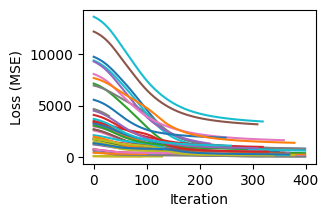

In [13]:
# Look at the loss curves
plt.figure(figsize=(3, 2))
for i in range(len(losses)):
    l = np.array(losses[i])
    plt.plot(l)
plt.xlabel("Iteration")
plt.ylabel("Loss (MSE)");

In [14]:
dorsal_inds = np.where(cell_nums < 60)[0]
ventral_inds = np.where(cell_nums > 60)[0]

final_losses = np.array([l[-1] for l in losses])
dorsal_losses = final_losses[dorsal_inds]
ventral_losses = final_losses[ventral_inds]

best_dorsal_loss_inds = np.argsort(dorsal_losses)[:15]
best_ventral_loss_inds = np.argsort(ventral_losses)[:15]

print(f"Best dorsal losses: {dorsal_losses[best_dorsal_loss_inds]}")
print(f"Best ventral losses: {ventral_losses[best_ventral_loss_inds]}")

Best dorsal losses: [ 49.85788727  72.49438477  86.73723602 173.77705383 178.27722168
 181.20272827 204.61473083 217.38064575 235.0131073  243.12313843
 279.78637695 293.14401245 308.03100586 321.00622559 322.55215454]
Best ventral losses: [ 108.64248657  113.19147491  117.4320755   136.82273865  241.9132843
  396.28759766  438.72375488  445.81970215  804.54388428  813.17456055
  874.60003662 1001.31994629 1123.37475586 1891.47412109 3190.86889648]


In [15]:
best_dorsal_cells = cell_nums[dorsal_inds[best_dorsal_loss_inds]]
best_ventral_cells = cell_nums[ventral_inds[best_ventral_loss_inds]]
print(best_dorsal_cells, best_ventral_cells) # best cell nums

best_dorsal_inds = np.where(np.isin(cell_nums, best_dorsal_cells))[0]
best_ventral_inds = np.where(np.isin(cell_nums, best_ventral_cells))[0]
print(best_dorsal_inds, best_ventral_inds) # indices of cell_nums where the best cell nums are

all_best_inds = list(best_dorsal_inds) + list(best_ventral_inds)
best_trained_params = [trained_params[i] for i in all_best_inds]
len(all_best_inds)


[ 6  9  8 14  3 10 11 17 16  5 20  0 25 19 27] [65 64 67 66 61 63 73 68 74 62 75 70 76 72 71]
[ 1  3  8 10 17 18 21 22 24 27 28 29 31 38 40] [ 0  2  4  5 11 12 13 16 23 25 30 32 34 35 39]


30

In [ ]:
# Get the solutions for all the trained parameters
final_solns = []
for t_params in trained_params:
    # Make the values jax numpy arrays
    t_params = [
        {key: jnp.array([value], dtype=jnp.float32) for key, value in d.items()}
        for d in t_params
    ]
    final_soln = simulate(t_params, stim)
    final_soln = final_soln[:: int(fs / dt)]
    final_soln -= final_soln[0]
    final_solns.append(final_soln)

In [56]:
with open("../../paper/fig2/notebooks/ribbon_solns.pkl", "wb") as f:
    pickle.dump(final_solns, f)

### KDE pairplots

In [57]:
# Parameter names
p_names = [list(i.keys()) for i in trained_params[0]]
p_names = [p[0] for p in p_names]
p_names, len(p_names)

(['alphas',
  'RibbonSynapse_gS',
  'RibbonSynapse_e_max',
  'RibbonSynapse_r_max',
  'RibbonSynapse_i_max',
  'RibbonSynapse_d_max',
  'RibbonSynapse_k',
  'RibbonSynapse_V_half'],
 8)

In [58]:
# Reformatting
p_dict = {p: [] for p in p_names}
for n in trained_params:
    for i, p in enumerate(p_names):
        p_dict[p].append(n[i][p])
    
p_dict_stacked = {p: np.stack(p_dict[p]) for p in p_names}
p_dict_stacked.pop('RibbonSynapse_gS');

In [ ]:
def calc_bw(data):
    n, d = data.shape
    sigma = np.std(data, axis=0)
    return 1.06 * sigma * n ** (-0.2)

# Separate KDE from plotting
xxs = {k: {} for k in p_dict_stacked.keys()}
yys = {k: {} for k in p_dict_stacked.keys()}
zs = {k: {} for k in p_dict_stacked.keys()}

for i, key in enumerate(p_dict_stacked):
    for j, key2 in enumerate(p_dict_stacked):
        if j > i:
            x = p_dict_stacked[key2]
            y = p_dict_stacked[key]
            dists = np.vstack([x, y]).T
            xmin, xmax = x.min(), x.max()
            ymin, ymax = y.min(), y.max()
            xx, yy = np.meshgrid(
                np.linspace(xmin, xmax, 100),
                np.linspace(ymin, ymax, 100)
            )
            xy_sample = np.vstack([xx.ravel(), yy.ravel()]).T
            bandwidth = calc_bw(dists)
            # Need to somehow average them for a good resolution of both
            bandwidth_scalar = np.mean(bandwidth)
            kde = KernelDensity(bandwidth=bandwidth_scalar, metric='euclidean', kernel='gaussian', algorithm='ball_tree')
            kde.fit(dists)
            z = np.exp(kde.score_samples(xy_sample))
            z = z.reshape(xx.shape)
            xxs[key][key2] = xx
            yys[key][key2] = yy
            zs[key][key2] = z

        elif i == j:
            # Add the 1D marginals (1d KDE)
            x = p_dict_stacked[key]
            dists = np.vstack([x]).T
            xmin, xmax = x.min(), x.max()
            xx = np.linspace(xmin, xmax, 100)[:, np.newaxis]
            xy_sample = np.vstack([xx.ravel()]).T
            bandwidth = calc_bw(dists)[0]
            kde = KernelDensity(bandwidth=bandwidth, metric='euclidean', kernel='gaussian', algorithm='ball_tree')
            kde.fit(dists)
            z = np.exp(kde.score_samples(xy_sample))
            z = z.reshape(xx.shape)
            xxs[key][key2] = xx
            zs[key][key2] = z
            
with open("../../paper/fig2/notebooks/ribbon_kde.pkl", "wb") as f:
    pickle.dump({"xxs": xxs, "yys": yys, "zs": zs}, f)  

### Spectral contrast comparison

In [60]:
def get_SCs(soln):
    # Get the green and uv stimulus sections
    readout_length = 600 # just longer than one sec, as they did
    uv_start = 1000
    green_sections = soln[:, :readout_length]
    uv_sections = soln[:, uv_start:uv_start+readout_length]
    # Calculate the areas
    green_areas = jax.vmap(jnp.trapezoid)(green_sections)
    uv_areas = jax.vmap(jnp.trapezoid)(uv_sections)
    # Calculate the selectivities
    sim_SCs = map(michelson_contrast, uv_areas.tolist(), green_areas.tolist())
    return list(sim_SCs)

final_solns_arr = jnp.vstack(final_solns)
sim_SCs = get_SCs(final_solns_arr)
data_SCs = get_SCs(all_data[cell_nums])

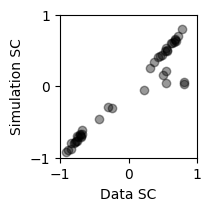

In [63]:
fig, axs = plt.subplots(figsize=(2, 2), layout="constrained")
axs.scatter(data_SCs, sim_SCs, c="k", alpha=0.4)
axs.set_xlabel("Data SC")
axs.set_ylabel("Simulation SC")
axs.spines["bottom"].set_bounds([-1, 1])
axs.spines["left"].set_bounds([-1, 1])
axs.set_xticks([-1, 0, 1])
axs.set_yticks([-1, 0, 1]);

In [64]:
with open("../../paper/fig2/notebooks/SC_comps.pkl", "wb") as f:
    pickle.dump({"sim_SCs": sim_SCs, "data_SCs": data_SCs}, f)